# SCHOOLS: Ranking School Examination Results Using Multivariate Hierarchical Models

In [1]:
import tqdm 
import pprint

import numpy as np
import matplotlib.pyplot as plt

## Données

In [2]:
import json 

with open("data/data.json") as file:
    data = json.load(file)
    
with open("data/init.json") as file:
    init = json.load(file)
    
with open("data/params.json") as file:
    params = json.load(file)

In [3]:
for idx, item in data.items():
    data[idx] = np.array(item).reshape(-1)

for idx, item in init.items():
    init[idx] = np.array(item).reshape(-1)
    
for idx, item in params.items():
    params[idx] = np.array(item).reshape(-1)

## Echantillonneur MCMC

In [4]:
def sampler(nchain, data, init, sd_proposal):
    # Data preparation and hyperparameters
    N = int(data["N"])
    M = int(data["M"])

    R = data["R"].reshape(3, 3)
    Omega0 = init["Omega"].reshape(3, 3)
    gamma0 = np.zeros(3)
    tau0 = 1e-4

    Gender = data["Gender"]
    School = data["school"]
    School_denom = data["School_denom"].reshape(-1, 3, order="F")
    School_gender = data["School_gender"].reshape(-1, 2, order="F")

    Y = data["Y"]
    VR = data["VR"].reshape(-1, 2, order="F")
    LRT = data["LRT"]

    # defintion of u and v 
    v = np.hstack((np.power(LRT, 2).reshape(-1,1), VR[:, [1]], Gender.reshape(-1,1) , School_gender, School_denom))

    # définition de u
    u = np.transpose(np.vstack((np.ones(N), LRT, VR[:, 0])))

    # initialisation des paramètres
    param_init = dict()

    param_init["theta"] = init["theta"][0]
    param_init["phi"] = init["phi"][0]
    param_init["gamma"] = init["gamma"]
    param_init["beta"] = init["beta"]
    param_init["T"] = np.eye(3)
    param_init["alpha"] = init["alpha"].reshape(-1, 3)
    
    # initialisation de la chaine
    chain = dict()

    chain["theta"] = np.zeros(nchain+1)
    chain["phi"] = np.zeros(nchain+1)
    chain["gamma"] = np.zeros((nchain+1, 3))
    chain["beta"] = np.zeros((nchain+1, 8))
    chain["T"] = np.zeros((nchain+1, 3, 3))
    chain["alpha"] = np.zeros((nchain+1, M, 3))

    for param, param_chain in chain.items():
        chain[param][0] = param_init[param]

    # initialisation de history pour calculer les taux d'acceptation
    history = dict()
    
    history["theta"] = 0
    history["phi"] = 0
    history["T"] = 0
    
    # constantes utiles
    LRT_sum = np.sum(data["LRT"])

    T0 = np.linalg.pinv(Omega0)
    R_inv = np.linalg.pinv(R)

    # initialisation de mu et tau
    mu_current  = np.zeros(N) 
    mu1_current  = np.zeros(N) 
    mu2_current  = np.zeros(N)

    T_proposal = np.zeros((3,3))

    # mise à jour des paramètres
    for i in tqdm.tqdm(range(1, nchain+1)):
        # mise à jour de alpha: normale
        ## calcul de tau
        theta_current = chain["theta"][i-1]
        phi_current = chain["phi"][i-1]
        tau_current = np.exp(theta_current + phi_current * LRT)

        ## variables intervenant dans la loi de alpha
        beta_current = chain["beta"][i-1]
        mu2_current = np.dot(v, beta_current) 

        gamma_current = chain["gamma"][i-1]
        T_current = chain["T"][i-1]
        for j in range(1, M+1):
            school_j = (School == j)
            tau_j = tau_current[school_j]
            u_j = u[school_j, :]
            v_j = v[school_j, :]
            Y_j = Y[school_j]

            n_j = len(Y_j)
            alphaj_cov_inv = T_current
            for k in range(n_j):
                u_kj =  u[[k], :]
                alphaj_cov_inv = alphaj_cov_inv + tau_j[k] * np.dot(u_kj.T, u_kj)
            alphaj_cov = np.linalg.pinv(alphaj_cov_inv)

            alphaj_mean = np.dot(T_current, gamma_current)
            for k in range(n_j):
                alphaj_mean = alphaj_mean + tau_j[k] * (Y_j[k] - np.dot(beta_current, v_j[k, :])) * u[k, :]
            alphaj_mean = np.dot(alphaj_cov, alphaj_mean)

            alphaj_proposal = np.random.multivariate_normal(alphaj_mean, alphaj_cov)
            chain["alpha"][i, j-1] = alphaj_proposal

        alpha_current = chain["alpha"][i]

        # mise à jour de mu_1 (car elle dépend de alpha)
        for j in range(1, M + 1):
            school_j = (School== j)
            alpha_j = alpha_current[j-1]
            mu1_current[school_j] = np.dot(u[school_j, :], alpha_j) 
        mu_current = mu1_current + mu2_current

        # mise à jour de beta: normale multivariée        
        beta_cov_inv = tau0 * np.eye(8) 
        for k in range(N):
            beta_cov_inv = beta_cov_inv + tau_current[k] * np.dot(v[[k], :].T, v[[k], :])
        beta_cov = np.linalg.pinv(beta_cov_inv)

        tmp = np.zeros(v.shape)
        for k in range(N):
            alpha_j = alpha_current[School[k]-1]
            tmp_k = tau_current[k] * (Y[k] - np.dot(alpha_j, u[k, :]))
            tmp_k = tmp_k * v[k, :]
            tmp[k, :] = tmp_k
        beta_mean = np.sum(tmp, axis=0)
        beta_mean = np.dot(beta_cov, beta_mean)

        beta_proposal = np.random.multivariate_normal(beta_mean, beta_cov)

        chain["beta"][i] = beta_proposal
        beta_current = beta_proposal
        mu2_current = np.dot(v, beta_current)
        mu_current = mu1_current + mu2_current

        # mise à jour de phi: M.-H. 
        # phi peut prendre toutes les valeurs réelles, 
        # donc on utilise le "random walk M.-H. scheme"
        phi_proposal = phi_current + np.random.normal(scale=sd_proposal["phi"])

        phi_top = - tau0 * np.power(phi_proposal, 2)
        phi_top = phi_top + LRT_sum * phi_proposal
        phi_top = phi_top - np.exp(theta_current) * np.sum(
            np.exp(phi_proposal*LRT) * np.power(Y-mu_current, 2)
        )
        phi_top = .5 * phi_top

        phi_bottom = -tau0 * np.power(phi_current, 2)
        phi_bottom = phi_bottom + LRT_sum * phi_current
        phi_bottom = phi_bottom - np.exp(theta_current) * np.sum(
            np.exp(phi_current*LRT) * np.power(Y-mu_current, 2)
        )
        phi_bottom = .5 * phi_bottom

        phi_acceptance = np.exp(phi_top-phi_bottom)
        if phi_acceptance > np.random.rand():
            chain["phi"][i] = phi_proposal
            phi_current = phi_proposal
            tau_current = np.exp(theta_current + phi_current * LRT)
            
            history["phi"] += 1
        else:
            chain["phi"][i] = phi_current

        # mise à jour de theta: M.-H. 
        # theta peut prendre toutes les valeurs réelles, 
        # donc on utilise le "random walk M.-H. scheme"        
        theta_proposal = theta_current + np.random.normal(scale=sd_proposal["theta"])

        theta_top = -tau0 * np.power(theta_proposal, 2)
        theta_top = theta_top + N * theta_proposal
        theta_top = theta_top - np.exp(theta_proposal) * np.sum(
            np.exp(phi_current*LRT) * np.power(Y-mu_current, 2)
        )
        theta_top = .5 * theta_top

        theta_bottom = -tau0 * np.power(theta_current, 2)
        theta_bottom = theta_bottom + N * theta_current
        theta_bottom = theta_bottom - np.exp(theta_current) * np.sum(
            np.exp(phi_current*LRT) * np.power(Y-mu_current, 2)
        ) 
        theta_bottom = .5 * theta_bottom

        theta_acceptance = np.exp(theta_top-theta_bottom)
        if theta_acceptance > np.random.rand():
            chain["theta"][i] = theta_proposal
            theta_current = theta_proposal
            tau_current = np.exp(theta_current + phi_current * LRT)
            
            history["theta"] += 1
        else:
            chain["theta"][i] = theta_current

        # mise à jour de gamma: normale
        alpha_current_sum = np.sum(alpha_current, axis=0)

        gamma_cov = np.linalg.inv(T0 + M*T_current)
        gamma_mean = np.dot(gamma_cov, np.dot(T0, gamma0) + np.dot(T_current, alpha_current_sum))

        gamma_proposal = np.random.multivariate_normal(gamma_mean, gamma_cov)

        chain["gamma"][i] = gamma_proposal
        gamma_current = gamma_proposal

        # mise à jour de T: M.-H.       
        T_flat_current = np.hstack((T_current[0,:], T_current[1,1:], T_current[2,2:]))
        # boucle pour garantir que T reste définie positive
        while True:
            T_flat_proposal =  np.random.normal(T_flat_current, scale=sd_proposal["T"], size=6)

            for k, (m, n) in enumerate(((0,0), (0,1), (0,2), (1,1), (1,2), (2,2))):
                T_proposal[m, n] = T_flat_proposal[k]
                T_proposal[n, m] = T_flat_proposal[k]

            if np.all(np.linalg.eigvals(T_proposal) > 0):
                break

        T_top = (M-1) * np.log(np.linalg.det(T_proposal))
        T_top = T_top - np.sum(np.diag(np.dot(R_inv, T_proposal))) 

        T_bottom = (M-1) * np.log(np.linalg.det(T_current))
        T_bottom = T_bottom - np.sum(np.diag(np.dot(R_inv, T_current))) 
        for j in range(M):
            diff_j = gamma_current - alpha_current[j]
            T_top = T_top - np.dot(diff_j.T, np.dot(T_proposal, diff_j))
            T_bottom = T_bottom - np.dot(diff_j.T, np.dot(T_current, diff_j))
        T_top = .5 * T_top
        T_bottom = .5 * T_bottom

        T_acceptance = np.exp(T_top - T_bottom)

        if T_acceptance > np.random.rand():
            chain["T"][i] = T_proposal
            T_current = T_proposal
            
            history["T"] += 1
        else:
            chain["T"][i] = T_current
    
    for param_name, param_count in history.items():
        history[param_name] = param_count / nchain
    
    return chain, history 

### Choix des écart-types pour M.-H.

In [ ]:
sd_proposal_grid = [
    (.2, .01, (.3, .3, .3, .3, .3, .3))    
]

sd_proposal = dict()
for u in sd_proposal_grid:
    sd_proposal["theta"] = u[0] 
    sd_proposal["phi"] = u[1]
    sd_proposal["T"] = u[2]
    
    _, history = sampler(1000, data,init, sd_proposal)
    pprint.pprint(history)
    pprint.pprint(u)
    
    if (.2<=history["theta"] <=.3) and (.2<=history["phi"] <=.3) and (.2<=history["T"] <=.3):
        sd_proposal["theta"] = u[0] 
        sd_proposal["phi"] = u[1]
        sd_proposal["T"] = u[2]
        
        print("Perfect :)")
        break

### Génération de la chaîne

In [6]:
sd_proposal = dict()

sd_proposal["theta"] = .2
sd_proposal["phi"] = .01
sd_proposal["T"] = (.3, .3, .3, .3, .3, .3)

chain, history = sampler(5000, data, init, sd_proposal)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [05:31<00:00, 15.09it/s]


In [7]:
for param_name, param_rate in history.items():
    print(f"Taux d'acceptation pour {param_name}: {param_rate}")

Taux d'acceptation pour theta: 0.2536
Taux d'acceptation pour phi: 0.2796
Taux d'acceptation pour T: 0.2648


### Visualisation des paramètres (partie M.-H.)

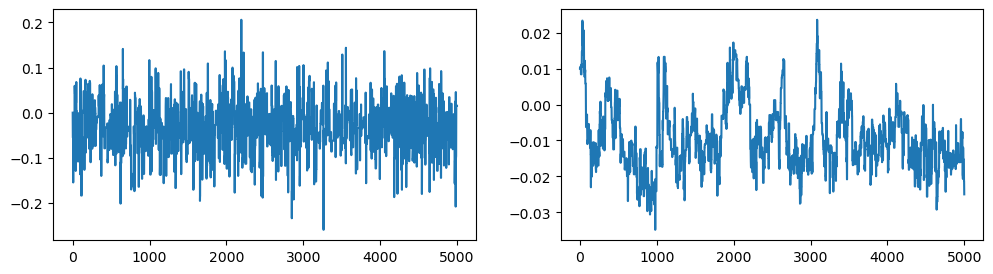

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))
axs[0].plot(chain["theta"])
axs[1].plot(chain["phi"])
plt.show()

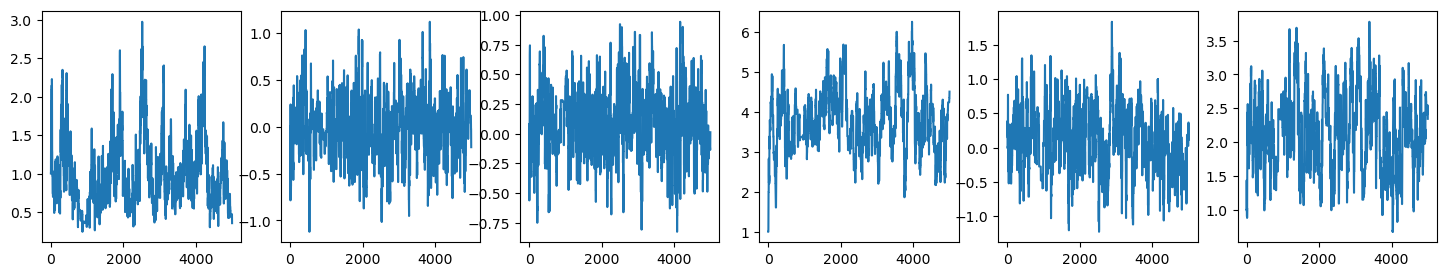

In [9]:
fig, axs = plt.subplots(1, 6, figsize=(18, 3))
for k, (m, n) in enumerate(((0,0), (0,1), (0,2), (1,1), (1,2), (2,2))): 
    axs[k].plot(chain["T"][:, m, n])

plt.show()

## Lois conditionnelles pleines

### Visualisation 

### Estimation ponctuelle

### Intervalles de crédibilité